In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import matplotlib
from roboflow import Roboflow
from PIL import Image
import cv2 
import xml.etree.ElementTree as et
from functools import reduce
from copy import deepcopy

In [2]:
# Only run this if you want to read/write files in parent directory
# os.chdir('..')
print(os.getcwd())

C:\Users\Nick\Documents\Classes\Current\Research\NASA\DataHandling


In [3]:
def update_data(version=8, fmt='voc'):
    rf = Roboflow(api_key="OYCys85yUllqTPobA5GG")
    project = rf.workspace("tid-detection").project("nasatiddetect")
    dataset = project.version(version).download(fmt)
    print(f'Saved Version {version} {fmt.upper()} files to folder')
    return

In [4]:
def retrieve_marylou_csv():
    df = pd.read_excel('ImgData.xlsx', index_col=0)
    print(os.listdir('2017_img_plots')[:10])
    four_year_shift = lambda x: x.replace(year = x.year - 4)
    df.index = pd.to_datetime(list(map(four_year_shift, df.index)))
    df.index.name = 'Date'
    df['TID Bool'] = df['TID, MLW'].astype(bool)
    df = df.drop('TID, MLW', axis=1)
    img_fmt = lambda date: f'spots_{date.strftime("%Y-%m-%d")}_T0_B20_RBN_WSPR_PSK_.jpg'
    df['Image Path'] = list(map(img_fmt, df.index))
    return df

In [5]:
def apply_dummy_height(df):
    df['Dummy Y0'] = np.random.normal(20, 5, size=df.shape[0])
    df['Dummy Y1'] = df['Dummy Y0'] + np.random.normal(5, 2, size=df.shape[0])
    def t_fmt(x):
        try:
            flt = float(x)
        except:
            flt = 0.0
        return flt

    df['Start time'] = df['Start time'].apply(t_fmt)
    df['End time'] = df['End time'].apply(t_fmt)
    df['Coords'] = list(zip(df['Start time'].round(1), df['Dummy Y0'].round(1), df['End time'].round(1), df['Dummy Y1'].round(1)))
    return df

In [6]:
def trim_df_for_save(df):
    df.loc[:,'Dummy Y0'] = -1
    df.loc[:,'Dummy Y1'] = -1

    # title case for columns
    df.columns = list(map(lambda x : x.title(), df.columns))

    
    trim_coords = ['xmin','ymin','xmax','ymax','Tid Hours','Cycles','Period','Train Set','Image Path']
    #select only certain columns
    df = df.rename(columns={'Start Time':'xmin','End Time':'xmax','Dummy Y0':'ymin','Dummy Y1':'ymax'}).loc[:,trim_coords]
    df.loc[:,'coords'] = list(zip(df['xmin'], df['ymin'], df['xmax'], df['ymax']))

    #add the 'd' character to the front of dates to prevent autoconversion
    date_prefix = lambda x : 'd' + x.strftime('%m-%d-%Y')
    df.index = list(map(date_prefix, df.index))
    df.index.name = 'Date'
    return df

def split_sets(df):
    set_A_df = df[df['Train Set'] == 'A']
    set_B_df = df[df['Train Set'] == 'B']
    display(set_A_df.head())
    display(set_B_df.head())
    
    set_A_df = trim_df_for_save(set_A_df)
    set_B_df = trim_df_for_save(set_B_df)
    
    set_A_df.to_csv('TID_set_Nick.csv')
    set_B_df.to_csv('TID_set_Lucas.csv')
    return

## Conversions
#### coordinates need to be converted between both plotted & cropped images, as well as between physical height and pixel height

In [7]:
IMG_SIZE = (719, 301, 3)
POSITIONS = ['xmin','ymin','xmax','ymax']
CROP_DIFS = (125, 844, 153, 454)

def uncrop_to_crop_coords(coords):
    xmin, ymin, xmax, ymax = coords
    xmin -= CROP_DIFS[0]
    ymin -= CROP_DIFS[2]
    xmax -= CROP_DIFS[0]
    ymax -= CROP_DIFS[2]
    return xmin, ymin, xmax, ymax

def crop_to_uncrop_coords(coords):
    xmin, ymin, xmax, ymax = coords
    xmin += CROP_DIFS[0]
    ymin += CROP_DIFS[2]
    xmax += CROP_DIFS[0]
    ymax += CROP_DIFS[2]
    return xmin, ymin, xmax, ymax

def convert_hour_to_pixel(hour):
    # converts given hour to cropped pixel width
    scale = IMG_SIZE[0] / 12
    x_loc = scale * hour
    return x_loc

def convert_height_to_pixel(height):
    # converts given physical height to cropped pixel height
    scale = IMG_SIZE[1] / 3000
    y_loc = 3000 - scale * height
    return y_loc

def convert_pixel_to_height(height):
    # converts given cropped vertical pixel location to physical height
    scale = 3000 / IMG_SIZE[1]
    height = 3000 - height * scale
    return height

def convert_pixel_to_hour(x_loc):
    # converts cropped p to cropped pixel width
    scale =  12 / IMG_SIZE[0]
    hour = scale * x_loc
    return hour

def convert_coords_to_pixel(coords):
    xmin, xmax = convert_hour_to_pixel(coords[0]), convert_hour_to_pixel(coords[2])
    ymin, ymax = convert_height_to_pixel(coords[1]), convert_hour_to_pixel(coords[3])
    return xmin, ymin, xmax, ymax
    
def convert_plot_coords(plot_coords, reverse=False):
    if reverse:
        xmin, xmax = plot_coords[0] + 125, plot_coords[2] + 125
        ymin, ymax = plot_coords[1] + 153, plot_coords[3] + 153
    else:
        xmin, xmax = plot_coords[0] - 125, plot_coords[2] - 125
        ymin, ymax = plot_coords[1] - 153, plot_coords[3] - 153
    return xmin, ymin, xmax, ymax

In [8]:
def copy_elem(elem):
    return et.fromstring(et.tostring(elem))

def print_elem(elem):
    elem = et.tostring(elem)
    elem = elem.decode('utf-8')
    print(elem)
    return

def remove_polygons(tree):
    tree = copy_elem(tree)
    for obj in tree.findall('object'):
        for poly in obj.findall('polygon'):
            obj.remove(poly)
    return tree

# def remove_objects(tree):
#     tree = copy_elem(tree)
#     for obj in tree.findall('object'):
#         tree.remove(obj)
#     return tree

def print_tree_no_poly(tree):
    tree = remove_polygons(tree)
    print_elem(tree)
    return

int_round_text = lambda x : int(round(float(x.text), 0)) 
def read_coords(tree):
    coord_list = list()
    for obj in tree.findall('object'):
        for bndbox in obj.findall('bndbox'):
            xmin = bndbox.find('xmin')
            ymin = bndbox.find('ymin')
            xmax = bndbox.find('xmax')
            ymax = bndbox.find('ymax')
            temp_coords = tuple(map(int_round_text, (xmin, ymin, xmax, ymax)))
            coord_list.append(temp_coords)
    return coord_list
    
def replace_bndbox_coords(bndbox, coords):   
    assert len(coords) == len(POSITIONS)
    for pos, coord in zip(POSITIONS, coords):
        bndbox.find(pos).text = coord
    return

def replace_coord(tree, in_coords):
    tree = copy_elem(tree)
    coord_list = list()
    objs = tree.findall('object')
    assert len(objs) == 1
    bndboxs = objs[0].findall('bndbox')
    assert len(bndboxs) == 1
    replace_bndbox_coords(bndboxs[0], in_coords)
    return tree

def read_img_size(tree):
    sizes = tree.find('size')
    img_size_list = list()
    for size in sizes:
        img_size_list.append(int(size.text))
    img_size = tuple(img_size_list)
    return img_size

#     generic_obj = et.fromstring(et.tostring(generic_obj).decode('utf-8').replace('\n<object>','\n    <object>'))
def append_coords(tree, coordss, print_bool=False, suffix='_augmented.xml', clear_objs=False):
#     tree = et.parse(filename)
#     tree = remove_polygons(tree)
#     objs = tree.findall('object')
    base_obj = tree.find('object')
    root = tree.getroot()
    if clear_objs:
        for obj in tree.findall('object'):
            root.remove(obj)
    if print_bool: print_elem(root)

    for coords in coordss:
        generic_obj = deepcopy(base_obj)
        bndbox = generic_obj.find('bndbox')
        
        for position, coord in zip(POSITIONS, coords):
            bndbox.find(position).text = str(coord)
        
        tree.getroot().append(generic_obj)

    if print_bool: print_elem(tree.getroot())
        

    return tree

def split_date(path):
    file_name = path.split('/')[-1]
    date = file_name.split('_')[0]
    date = pd.to_datetime(date)
    return date

In [9]:
def transform_coords(coords, cycle_markers):
    cycle_markers.sort()
    xmin, ymin, xmax, ymax = coords
    for coord in coords:
        assert isinstance(coord, (int, float))
    a1 = (xmin, ymin, xmax, ymax)
    augmentations = [a1] # initialize list with first argument as raw coords

    try:
        first_period = cycle_markers[1]
    except:
        pass
    else:
        # add first period + eighths to bounding box
        for a_xmax in np.linspace(first_period, xmax, 8):
            new_a = (xmin, ymin, a_xmax, ymax)
            augmentations.append(new_a)
    scale = IMG_SIZE[0] / 12
    
    for i in range(5):
        new_a = (xmin + scale * np.random.uniform(0,1), ymin, xmax, ymax)
        augmentations.append(new_a)   
    
    for i in range(1, len(cycle_markers)):
        a_xmin = cycle_markers[i - 1]
        a_xmax = cycle_markers[i]
        new_a = (a_xmin, ymin, a_xmax, ymax)
        augmentations.append(new_a)
        
    for y_scale in [1.25, 1.5, 1.75]:
        dy = ymax - ymin
        yavg = (ymax + ymin) / 2
        dy = y_scale * dy
        a_ymax = yavg + dy / 2
        a_ymin = yavg - dy / 2
        new_a = (xmin, a_ymin, xmax, a_ymax)
        augmentations.append(new_a)
    
    print('number of augmented coords:', len(augmentations))
    return augmentations

def augment_coords_df(tid_df, conversion='hour'):
    # conversion in 'hour', 'plot', None
    for index, row in tid_df.iterrows():
        filename = row['Image Path'].replace('.jpg','.xml')
        coords = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        
        if conversion == 'hour': coords = convert_coords_to_pixel(coords)
        elif converison == 'plot': coords = convert_plot_coords(coords)
            
        coordss = transform_coords(coords)
        append_coords(filename, coordss)

def visualize_xml(img_path, xml_path):
#     img = Image.open(img_path)
    print('Visual XML path', xml_path)
    img = cv2.imread(img_path)
#     plt.imshow(img[:,:,::-1])
#     plt.show()
    tree = et.parse(xml_path)
    coordss = read_coords(tree)
    for coords in coordss:
        new_img = img.copy()
        xmin,ymin,xmax,ymax = map(int, coords)
#         xc, yc = (xmin + xmax) / 2, (ymin + ymax) / 2
#         w, h = (xmax - xmin), (ymax - ymin)
        print(xmin, ymin, xmax, ymax)
        new_img = cv2.rectangle(new_img, (xmin, ymin), (xmax, ymax), (0, 0, 255), 2)
        plt.imshow(new_img[:,:,::-1])
        plt.show()
        
def read_imgs_and_xml(directory):
    files = sorted(os.listdir(directory))
    img_paths = [directory + '/' + file for file in files if file.endswith('.jpg')]
    xml_paths = [directory + '/' + file for file in files if file.endswith('.xml')]
    return img_paths, xml_paths

def read_coords_from_dir(directory):
    img_paths, xml_paths = read_imgs_and_xml(directory)
    coord_list, date_list = list(), list()
    for img_path, xml_path in zip(img_paths, xml_paths):
        tree = et.parse(xml_path)
        root = tree.getroot()
        img_size = read_img_size(tree)
        coords = read_coords(tree)[0]
        print(coords)
        if img_size == (1000, 600, 3):
            coords = uncrop_to_crop_coords(coords)
        coord_list.append(coords)
        date = img_path.split('/')[-1].split('_')[0]
        date_list.append(date)
        print(date)
    coord_df = pd.DataFrame(index=pd.to_datetime(date_list))
    coord_df.index.name = 'Date'
    coord_df['xmin'], coord_df['ymin'], coord_df['xmax'], coord_df['ymax'] = zip(*coord_list)
    return coord_df


# print(os.getcwd())
# DIRECTORY = os.getcwd() + '/NasaTIDDetect-8/train'
# coord_df = read_coords_from_dir(DIRECTORY)
# coord_df['ymax'] = coord_df['ymax'].apply(convert_pixel_to_height)
# coord_df['ymin'] = coord_df['ymin'].apply(convert_pixel_to_height)

def min_max_height_plot(coord_df):
    matplotlib.style.use('ggplot')
    plt.figure(figsize=(16,8))
    plt.scatter(coord_df.index, coord_df.ymax, label='Min Height')
    plt.scatter(coord_df.index, coord_df.ymin, label='Max Height')
    plt.ylabel('Height(m)')
    plt.xlabel('Date')
    plt.title(coord_df.shape[0])
    plt.ylim(0, 3000)
    plt.legend()
    plt.show()
    coord_df.loc[:,['ymin','ymax']].rename(columns={'ymin':'Max Height(m)','ymax':'Min Height(m)'}).to_csv('temp.csv')
    return

In [12]:
# parent_dir = '2017_img_plots_set_A/'
# new_dir = '2017_gray_img_plots_set_A_cropped/'
# for img_path in os.listdir(parent_dir):
#     pass

def read_img(img_path, rgb=True):
    if rgb:
        img = cv2.imread(img_path)
    else:
        img = cv2.imread(img_path)[:,:,::-1]
    return img

def crop_plotted_img(img, grayscale=False):
    assert img.shape == (600,1000,3)
    img = img[CROP_DIFS[2]:CROP_DIFS[3],CROP_DIFS[0]:CROP_DIFS[1]]
    img_patch = img[0:100,0:200]
    img_patch[np.where((img_patch > [30,30,30]).all(axis=-1))] = [0,0,0]
    if grayscale: img = np.expand_dims(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), axis=2)
    return img

In [13]:
# visualize_xml('2017_img_plots_set_A_cropped/2017-01-02_plot_cropped.jpg', 'test_case1output.xml')
IMG_SIZE = (719, 301)
df1 = pd.read_csv('../TID_set_Lucas.csv', index_col=0)
df1.index = pd.to_datetime([idx.replace('d','') for idx in df1.index])
df2 = pd.read_csv('../TID_set_Nick.csv', index_col=0)
df = pd.concat((df1, df2), axis=0)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# img_paths, xml_paths = read_imgs_and_xml(DIRECTORY)
# for img_path, xml_path in zip(img_paths, xml_paths):
#     tree = et.parse(xml_path)
#     date = split_date(img_path)
#     print(date)

#     n_cycles = df.loc[date,'cycles']
#     try:
#         n_cycles = int(n_cycles)
#     except ValueError:
#         n_cycles = int(df['cycles'].mean())
#     coords = read_coords(tree)
#     if np.array(coords).ndim > 1: coords = coords[0]
#     cycle_markers = np.linspace(coords[0], coords[1], n_cycles)
#     augmentations = transform_coords(coords, cycle_markers)
#     tree = tree = et.parse(xml_path)
#     tree = append_coords(tree, augmentations)
#     new_xml_path = xml_path.replace('.xml','_augmented.xml')
# #     tree.write(new_xml_path)
#     visualize_xml(img_path, new_xml_path)

In [ ]:
import shutil
from PIL import Image

def color_augmentations_xml(
    src_dir, 
    target_dir, 
    img_aug_pipeline=None, 
    coord_aug_pipeline=None, 
    description='color_augment', 
    plot_bool=True, 
    grayscale=False, 
    target_size=None,
    clear_tree=False,
    write_df=True,
):
    conv_coords = False
    today = pd.to_datetime('today').strftime('%m-%d-%y')
    if not os.path.exists(target_dir): 
        print('Creating Directory: ', target_dir)
        os.mkdir(target_dir) 
    img_paths, xml_paths = read_imgs_and_xml(DIRECTORY)
    if write_df: df_list = list()
    for img_path, xml_path in zip(img_paths, xml_paths):
        
        date = split_date(img_path)
        
        img = read_img(img_path)
        tree = et.parse(xml_path)
        filename = tree.find('filename').text
        assert filename == img_path.split('/')[-1], filename
        
        if img.shape == (600,1000,3): 
            img = crop_plotted_img(img, grayscale=grayscale)
            conv_coords = True
        assert img.shape == (301,719,3), img.shape
        if target_size and img.shape != target_size:
            assert len(target_size) == 3
            img = img.resize(target_size)
            size_elem = tree.find('size')
            size_elem.find('width').text = target_size[0]
            size_elem.find('height').text = target_size[1]
            size_elem.find('depth').text = target_size[2]
        #~~~~~~~~~~~~~~~~~~~~~#
        if img_aug_pipeline: 
            img = img_aug_pipeline(img)
        #~~~~~~~~~~~~~~~~~~~~~#
        if coord_aug_pipeline:
            coords = read_coords(tree)[0]
            if conv_coords:
                coords = uncrop_to_crop_coords(coords)
                conv_coords = False
#                 coordss = [uncrop_to_crop_coords(coords) for coords in coordss]
            n_cycles = df.loc[date,'cycles']
            try:
                n_cycles = int(n_cycles)
            except ValueError:
                n_cycles = int(df['cycles'].mean())
            cycle_markers = np.linspace(coords[0], coords[1], n_cycles)
            
            coordss = coord_aug_pipeline(coords, cycle_markers)
            def coord_area(coords):
                h = coords[3] - coords[1]
                w = coords[2] - coords[0]
                return w * h
            
            def coord_check(coords):
                if coords[2] - coords[0] < 50:
                    return False
                return True

            def coord_bounds(coords):
                xmin, ymin, xmax, ymax = coords
                if xmax >= IMG_SIZE[0]: xmax = IMG_SIZE[0] - 1
                if xmin <= 0: xmin = 1
                if ymin <= 0: ymin = 1
                if ymax >= IMG_SIZE[1]: ymax = IMG_SIZE[1] - 1
                coords = tuple(map(int, [xmin, ymin, xmax, ymax]))
                print(coords)
                return coords
                    
            if clear_tree:
                root = tree.getroot()
                for obj in tree.findall('object'):
                    obj.remove(obj.find('occluded'))
                    obj.remove(obj.find('polygon'))
            coordss = [coord_bounds(coords) for coords in coordss if coord_check(coords)]
            tree = append_coords(tree, coordss, clear_objs=True)
            if write_df:
                xmin, ymin, xmax, ymax = zip(*coordss)
                temp_df = pd.DataFrame({
                    'filename' : filename,
                    'width' : IMG_SIZE[0],
                    'height' : IMG_SIZE[1],
                    'class' : [obj.find('name').text for obj in tree.findall('object')],
                    'xmin' : xmin,
                    'ymin' : ymin,
                    'xmax' : xmax, 
                    'ymax' : ymax,
                })
                df_list.append(temp_df)
        #~~~~~~~~~~~~~~~~~~~~~#
        description = description.replace(' ','_')
        try:
            tree.find('source').find('database').text = f'{description} augmented {today}'
        except:
            pass
        if not isinstance(date, str):
            date = date.strftime('%m-%d-%Y')
        img_file_name = '_'.join([date, description, f'{today}.jpg'])
        xml_file_name = '_'.join([date, description, f'{today}.xml'])
        for path_str in ['filename','path']:
            path = tree.find('filename')
            path.text = img_file_name

        new_img_path = os.path.join(target_dir, img_file_name)
        new_xml_path = os.path.join(target_dir, xml_file_name)
        if write_df:
            obj_df = pd.concat(df_list, axis=0)
            display(obj_df)
            csv_file_name = '_'.join([date, description, f'{today}_df.csv'])
            new_csv_path = os.path.join(target_dir, csv_file_name)
            obj_df.to_csv(new_csv_path)
        tree.write(new_xml_path)  
#         if isinstance(img, Image):
#             img.save(new_img_path)
        if isinstance(img, np.ndarray):
            cv2.imwrite(new_img_path, img)
        else:
            raise TypeError
        
        print(date)
        if plot_bool: visualize_xml(new_img_path, new_xml_path)
    print('Completed without error')
    return

# color_augmentations('NasaTIDDetect-8/train','NasaTIDDetect-8/augmented_train', coord_aug_pipeline=transform_coords, description='coord_transforms', clear_tree=True)

In [ ]:
from shutil import move, copy

setB = pd.read_csv('TID_set_Lucas.csv', index_col=0)
setA = pd.read_csv('TID_set_Nick.csv', index_col=0)
setB.index = pd.to_datetime([idx.replace('d','') for idx in setB.index])
setA.index = pd.to_datetime(setA.index)
# setB.index = pd.to_datetime([idx.replace('d','') for idx in setB.index])

directory = 'NasaTIDDetect-8/augmented_train'
set_A_dir = 'NasaTIDDetect-8/augmented_A'
set_B_dir = 'NasaTIDDetect-8/augmented_B'
if not os.path.exists(set_A_dir): os.mkdir(set_A_dir)
if not os.path.exists(set_B_dir): os.mkdir(set_B_dir)
for file in os.listdir(directory):
    if file.endswith(('.jpg','.xml','.csv')):
        date = file.split('_')[0]
        print(file)
        if date in setA.index:
            copy(directory + '/' + file, set_A_dir + '/' + file)
        elif date in setB.index:
            copy(directory + '/' + file, set_B_dir + '/' + file)
        else:
            print('Date not found')
            raise ValueError

In [ ]:
from roboflow import Roboflow

rf = Roboflow(api_key="OYCys85yUllqTPobA5GG")
project = rf.workspace("tid-detection").project("nasatiddetect")
dataset = project.version(8).download("tensorflow")

In [151]:
from pykuwahara import kuwahara


def gray_img(img):
#     img = img[:,:,::-1]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
    return img

def plot_img(img):
    try:
        plt.imshow(img[::-1,:,::-1])
    except IndexError:
        plt.imshow(img)
    plt.show()
    return

def zca_whitening_matrix(X):
    """
    Function to compute ZCA whitening matrix (aka Mahalanobis whitening).
    INPUT:  X: [M x N] matrix.
        Rows: Variables
        Columns: Observations
    OUTPUT: ZCAMatrix: [M x M] matrix
    """
    # Covariance matrix [column-wise variables]: Sigma = (X-mu)' * (X-mu) / N
    sigma = np.cov(X, rowvar=True) # [M x M]
    # Singular Value Decomposition. X = U * np.diag(S) * V
    U,S,V = np.linalg.svd(sigma)
        # U: [M x M] eigenvectors of sigma.
        # S: [M x 1] eigenvalues of sigma.
        # V: [M x M] transpose of U
    # Whitening constant: prevents division by zero
    epsilon = 1e-5
    # ZCA Whitening matrix: U * Lambda * U'
    ZCAMatrix = np.dot(U, np.dot(np.diag(1.0/np.sqrt(S + epsilon)), U.T)) # [M x M]
    X = np.dot(ZCAMatrix, X)
    return X

start


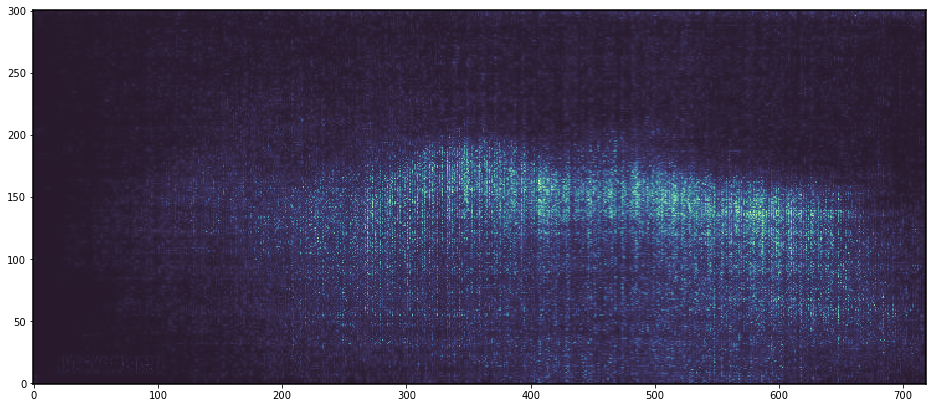

0 0.0
63 126.0
126 189.0
189 189.0
252 189.00029110218748


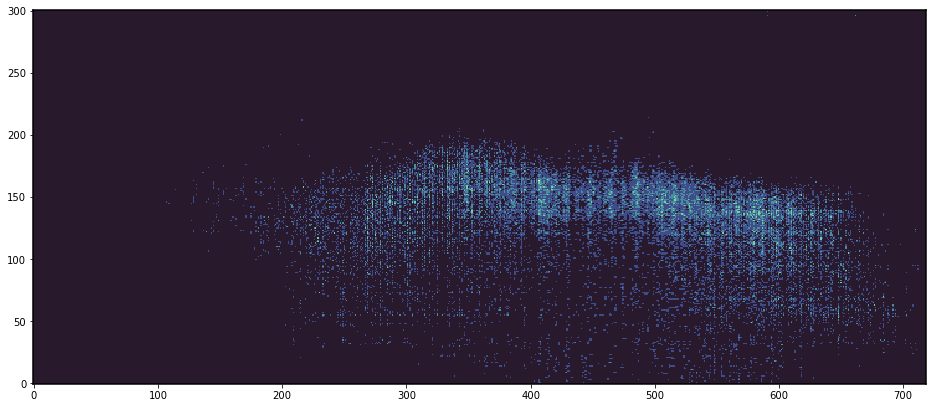

end


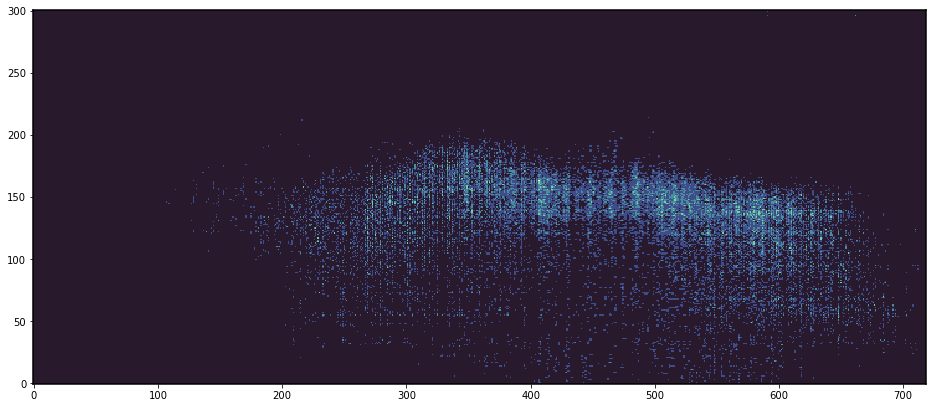

719


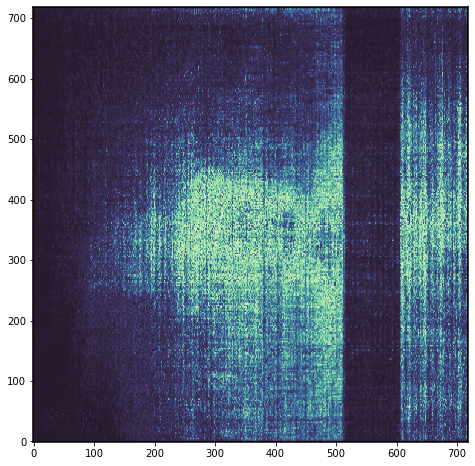

[  0  24  36  48  60  72  84  96 108 120 132 144 156 168 180 192 204 216
 228 252]


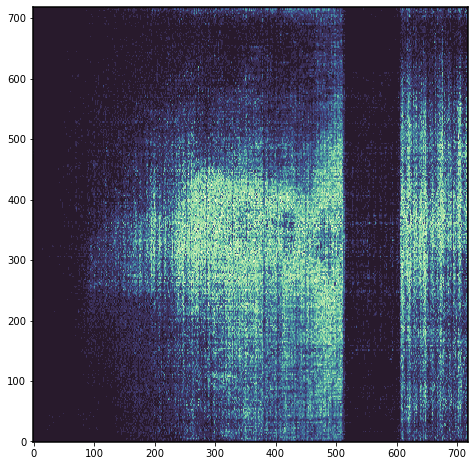

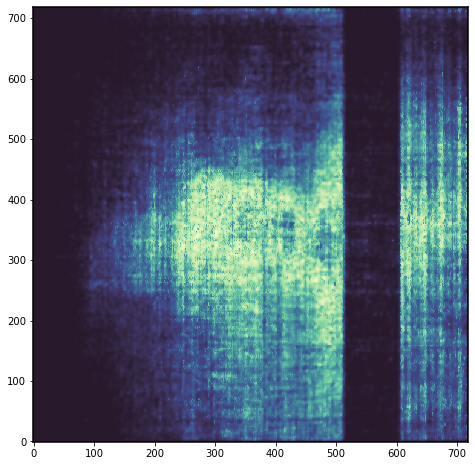

In [203]:
# import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)


# img = gray_img(img)
# plot_img(img)
# img = zca_whitening_matrix(img)
# plot_img(img)

# img = kuwahara(img, method='mean', radius=3)
# img = cv2.Canny(img,200,200)
# print(ranges)

# plot_img(img)

import skimage
import seaborn_image as isns
from skimage.exposure import adjust_gamma

def sharpen_img(img):
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
    return img

def make_discrete(arr, n_steps=8):
    arr_range = np.amax(arr) - np.amin(arr)
    arr = arr - np.amin(arr)
    factor = arr_range // n_steps
    arr = np.divide(arr, factor)
#     print(np.amax(arr))
#     print(np.amin(arr))
#     print(len(np.unique(arr)))
    arr = arr.astype(np.uint8)
#     print(len(np.unique(arr)))
    mult_factor = 255 // n_steps
    arr = np.multiply(arr, mult_factor)
#     print(np.amax(arr))
#     print(np.amin(arr))
    return arr

def remove_top_bottom_discrete(img):
    if img.dtype != np.uint8:
        img = make_discrete(img)
    vals = np.sort(np.unique(arr))
    img[img == vals[1]] = 0
    img[img == vals[-2]] = vals[-1]
    vals = np.sort(np.unique(img))
    return img

def trim_below(img, thresh=30):
    assert img.dtype == np.unint8, 'must be int array'
    img[img <= thresh] = 0
    return img
    
def trim_above(img, thresh=220):
    assert img.dtype == np.unint8, 'must be int array'
    img[img >= thresh] = 0
    return img
    
def contrast(img):
# https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Stacking the original image with the enhanced image
#     result = np.hstack((img, enhanced_img))
#     cv2.imshow('Result', result)
    return img

from statsmodels.distributions.empirical_distribution import ECDF
def find_first(arr, val):
    return np.argmax(np.sort(arr.flatten()) == val)


#     img2_vals = np.unique(img2)
#     img2_sorted = np.sort(img2.flatten())
#     img2_len = np.prod(img2.shape)
    

def median_smooth(img):
# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_filtering/py_filtering.html
    img = cv2.medianBlur(img,1)
    return img

def bilateral_smooth(img):
    img = cv2.bilateralFilter(img, 9, 75, 75)
    return img

def square_resize(img):
    x_shape = img.shape[1]
    print(x_shape)
    dim = (x_shape, x_shape)
    img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    return img

def transform_a_to_b(img1, img2, n_steps=8):
    assert img1.shape == img2.shape, f'shapes must match {img1.shape} != {img2.shape}'
    # get quantiles THEN convert to int?
    img1 = make_discrete(img1, n_steps=n_steps)
    img2 = make_discrete(img2, n_steps=n_steps)
    img1_vals = np.unique(img1)
    img1_len = np.prod(img1.shape)
    pair_list = list()
    for img1_val in img1_vals:
        a = find_first(img1, img1_val) / img1_len
        b = np.quantile(img2.flatten(), a)
        pair = (a, b)
        print(img1_val, b)
        pair_list.append(pair)
        
    for pair in pair_list:
        a, b = pair
        img1[img1 == a] = b
    
    return img1, img2

img_dir = 'csv_augmented/2017_v6/train/'
img_paths = [os.path.join(img_dir, img_path) for img_path in sorted(os.listdir(img_dir)) if img_path.endswith('.jpg')]
# dir_img = 'csv_augmented/2017_v6/train/2017-01-02_v2.jpg'
img = cv2.imread(img_paths[-1])

img1 = cv2.imread(img_paths[0])
img2 = cv2.imread(img_paths[-1])

img1, img2 = gray_img(img1), gray_img(img2)
print('start')
plot_img(img1)
img1, img2 = transform_a_to_b(img1, img2, n_steps=4)
plot_img(img1)

print('end')


img = gray_img(img)
plot_img(make_discrete(img1, n_steps=8))
img = square_resize(img)
plot_img(img)
img = make_discrete(img, n_steps=20)
img = remove_top_bottom(img)
plot_img(img)
img = bilateral_smooth(img)
plot_img(img)

# img = contrast(img)
# img = skimage.filters.sobel(img)
# img = sharpen_img(img)
# plot_img(img)
# isns.imgplot(img, map_func=adjust_gamma, gamma=0.5, robust=True)

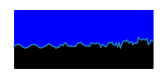

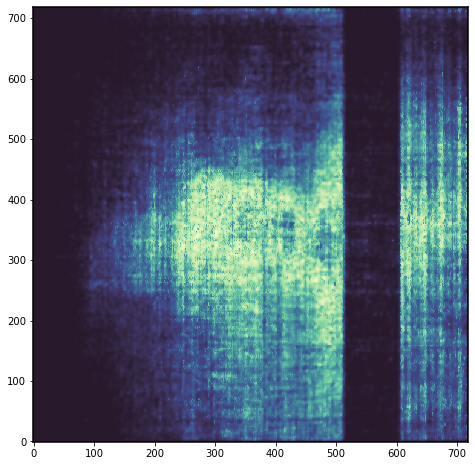

(719, 719)
(719,)


TypeError: Invalid shape (719,) for image data

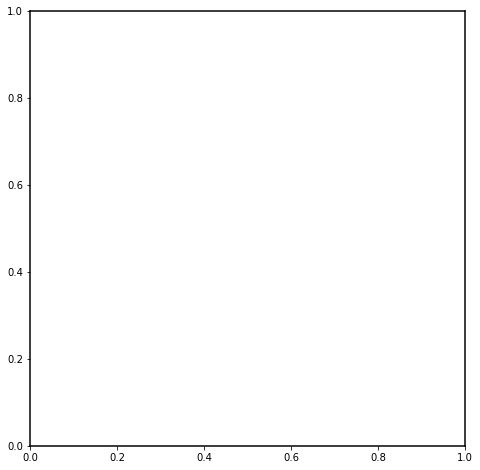

In [204]:
# https://stackoverflow.com/questions/22566692/python-how-to-plot-graph-sine-wave
fs = 100 # sample rate 
f = 9
# from wand.image import Image

def blur_img(img, ksize=(7,7)):
    img = cv2.blur(img, ksize)
    return img
                 
x = np.arange(fs)
y = np.sin(2*np.pi*f * (x/fs)) 

noise_arr = np.random.normal(size=len(y))
offset_arr = np.linspace(0, 3, len(y))
noise_arr = np.multiply(x / 2, noise_arr + offset_arr) / 10

y = y * 5
y = np.add(noise_arr, y)

# y1 = 
# plt.stem(x,y, 'r', )
# https://stackoverflow.com/questions/8218608/scipy-savefig-without-frames-axes-only-content
fig = plt.figure(frameon=False)
fig.set_size_inches(IMG_SIZE[0] / 340,IMG_SIZE[1] / 340)

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.plot(x,y)
ax.fill_between(x,y,100, color='b')
ax.fill_between(x,-60,y, color='k')

fig.savefig('temp_file.jpg', dpi=300)
plt.show()

def stratify(img, scale=15):
    print(img.shape)
    rand_val = np.random.normal(size=img.shape[1])
    print(rand_val.shape)
    rand_val = np.repeat(np.expand_dims(rand_val, axis=0), img.shape[0], axis=0)
#     rand_val = np.repeat(np.expand_dims(rand_val, axis=-1), 3, axis=2)
    print(rand_val.shape)
    rand_val = np.multiply(rand_val, scale)
    img[:,:,0] = np.add(img[:,:,0], rand_val)
    return img

def random_flip(img, chance=.2, scale=15, axis=0):
    if not axis: img = img.transpose()
    arr_list = list()
    print(img.shape)
    for arr in img:
        rand_val = np.random.normal(size=1)
        if rand_val < .2:
            arr = np.flip(arr)
    arr_list.append(arr)
    img = np.hstack(arr_list)
    print(img.shape)
    if not axis: img = img.transpose()
    return img

plot_img(img)
img = random_flip(img)
plot_img(img)
    
img = cv2.imread('temp_file.jpg')
plot_img(img)
img = blur_img(img)
plot_img(img)
print(img.shape)
noise_len = np.prod(img.shape)
img = img + np.random.poisson(size=noise_len).reshape(img.shape) 
plot_img(img)

In [ ]:
# https://stackoverflow.com/questions/22566692/python-how-to-plot-graph-sine-wave
fs = 100 # sample rate 
f = 5

def blur_img(img, ksize=(10,10)):
    img = cv2.blur(img, ksize)
    return img
                 
x = np.arange(fs)
y = np.sin(2*np.pi*f * (x/fs)) 

noise_arr = np.random.normal(size=len(y))

y = y * 5
y = np.add(noise_arr, y)

# plt.stem(x,y, 'r', )
# https://stackoverflow.com/questions/8218608/scipy-savefig-without-frames-axes-only-content
fig = plt.figure(frameon=False)
fig.set_size_inches(IMG_SIZE[0],IMG_SIZE[1])

ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)

ax.plot(x,y)
ax.fill_between(x,y,100, color='b')
ax.fill_between(x,-60,y, color='k')

fig.savefig('temp_file.jpg', dpi=300)
plt.show()

img = cv2.imread('temp_file.jpg')
plot_img(img)

In [54]:
IMG_SIZE = (719, 301)
def visualize_csv(csv_path):
    dir_name = os.path.dirname(csv_path)
    subset = csv_path.split('/')[-1].split('_')[0]
    dir_name = os.path.join(dir_name, subset)
    df = pd.read_csv(csv_path).set_index('filename')
    prev_img_path = None
    for img_path, row in df.iterrows():
        if img_path != prev_img_path:
            img = cv2.imread(os.path.join(dir_name, img_path))
            prev_img_path = img_path
        new_img = cv2.rectangle(img, (row['xmin'], row['ymin']), (row['xmax'], row['ymax']), (0, 0, 255), 2)
        plt.imshow(new_img[:,:,::-1])
        plt.show()
    return
        
def coord_bounds(coords):
    xmin, ymin, xmax, ymax = coords
    if xmax >= IMG_SIZE[0]: xmax = IMG_SIZE[0] - 1
    if xmin <= 0: xmin = 1
    if ymin <= 0: ymin = 1
    if ymax >= IMG_SIZE[1]: ymax = IMG_SIZE[1] - 1
    coords = tuple(map(int, [xmin, ymin, xmax, ymax]))
    return coords

def color_augmentations_csv(
    csv_src, 
    dst_dir, 
    img_aug_pipeline=None, 
    coord_aug_pipeline=None, 
    description='color_augment', 
    suffix='_v2',
    plot_bool=True, 
    grayscale=False, 
    target_size=None,
):
    conv_coords = False
    today = pd.to_datetime('today').strftime('%m-%d-%y')
    if not os.path.exists(dst_dir): 
        print('Creating Directory: ', dst_dir)
        split_dir = list(dst_dir.split('/'))
        for i in range(1, len(split_dir)):
            os.mkdir('/'.join(split_dir[:i]))
    src_dir = '/'.join(csv_src.split('/')[:-1])
    anno_df = pd.read_csv(csv_src, index_col=0)
#     conv_df = pd.DataFrame()
    df_list = list()
    for img_path, row in anno_df.iterrows():
        date = split_date(img_path)
        #*************************#
        img_filename = img_path.split('/')[-1].split('_')[0] + suffix + '.jpg'
        print(img_filename)
        #*************************#
        print(src_dir, img_path)
        img_src = os.path.join(src_dir, img_path)
        img = read_img(img_src)
       
        if img.shape == (600,1000,3): 
            img = crop_plotted_img(img, grayscale=grayscale)
            conv_coords = True
        
        assert img.shape == (301,719,3), img.shape
        if target_size and img.shape != target_size:
            assert len(target_size) == 3
            img = img.resize(target_size)

        #~~~~~~~~~~~~~~~~~~~~~#
        if img_aug_pipeline: 
            img = img_aug_pipeline(img)
        #~~~~~~~~~~~~~~~~~~~~~#
        if coord_aug_pipeline:

            coords = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            if conv_coords:
                coords = uncrop_to_crop_coords(coords)
                conv_coords = False
            
            # This should be in coord_aug_pipeline #
            n_cycles = df.loc[date,'cycles']
            try:
                n_cycles = int(n_cycles)
            except ValueError:
                n_cycles = int(df['cycles'].mean())
                
            cycle_markers = np.linspace(coords[0], coords[1], n_cycles)
            #########################################
            coordss = coord_aug_pipeline(coords, cycle_markers)
            
            def coord_area(coords):
                h = coords[3] - coords[1]
                w = coords[2] - coords[0]
                return w * h
            
            def coord_check(coords):
                if coords[2] - coords[0] < 50:
                    return False
                return True
  
            coordss = [coord_bounds(coords) for coords in coordss if coord_check(coords)]
            xmins, ymins, xmaxs, ymaxs = zip(*coordss)
        else:
            xmins, ymins, xmaxs, ymaxs = coord_bounds([row[key] for key in ['xmin','ymin','xmax','ymax']])
        temp_df = pd.DataFrame({
            'filename' : img_filename,
            'width' : img.shape[0],
            'height' : img.shape[1],
            'class' : row['class'],
            'xmin' : xmins,
            'ymin' : ymins,
            'xmax' : xmaxs,
            'ymax' : ymaxs,
        })
        new_img_dst = os.path.join(dst_dir, img_filename)
        if isinstance(img, np.ndarray):
            cv2.imwrite(new_img_dst, img)
        else:
            raise TypeError('Image not a numpy array, could handle PIL here')
#         if plot_bool: visualize_csv(new_img_path, new_xml_path)
        df_list.append(temp_df)
    csv_dst = 'test_train_labels.csv'
    new_csv_path = os.path.join(dst_dir, csv_dst)    
    final_anno_df = pd.concat(df_list, axis=0)
    final_anno_df.to_csv(new_csv_path, index=False)
    print('Completed without error')
    return

def pull_unlabeled(src_dir, dst_dir, csv_path, suffix='_v2', grayscale=False):
    img_paths = [img_path for img_path in os.listdir(src_dir) if img_path.endswith('.jpg')]
    img_filenames = list()
    df = pd.read_csv(csv_path)
    filenames = df['filename'].unique()
    for img_path in img_paths:
#         date = img_path.split('_')[0]
        #*************************#
        img_filename = img_path.split('/')[-1].split('_')[0] + suffix + '.jpg'
        if img_filename in filenames:
            continue
        print(img_filename)
        #*************************#
        print(src_dir, img_path)
        img_src = os.path.join(src_dir, img_path)
        img = read_img(img_src)
        if img.shape == (600,1000,3): 
            img = crop_plotted_img(img, grayscale=grayscale)
        
        new_img_dst = os.path.join(dst_dir, img_filename)
        cv2.imwrite(new_img_dst, img)
        img_filenames.append(img_filename)
    n_imgs = len(img_filenames)
    empty_list = [np.nan for _ in range(n_imgs)]
    append_df = pd.DataFrame({
        'filename' : img_filenames,
        'width' : img.shape[0],
        'height' : img.shape[1],
        'class' : empty_list,
        'xmin' : empty_list,
        'ymin' : empty_list,
        'xmax' : empty_list,
        'ymax' : empty_list,
    }) 
    new_df = pd.concat((df, append_df), axis=0)
    new_df = new_df.sort_values('filename')
    cols = [col for col in new_df if 'Unnamed' not in col]
    new_df = new_df.loc[:,cols]
    new_df.to_csv(csv_path, index=False)
    return new_df

def set_test_train_dfs(csv_path, test=.2, train=.7, valid=.1, remove_nan=False, split_dirs=True):
    df = pd.read_csv(csv_path)
    if remove_nan: df = df.dropna()
    df = df.sample(frac=1)
    assert np.round(test + train + valid, 3) == 1, train + test + valid
    n_rows = df.shape[0]
    len_train = math.ceil(train * n_rows)
    len_test = math.ceil(test * n_rows)
    len_valid = n_rows - (len_train + len_test)
    assert len_train + len_test + len_valid == n_rows
    train_df = df.iloc[0:len_train,:]
    test_df = df.iloc[len_train:len_test + len_train,:]
    valid_df = df.iloc[len_test + len_train:,:]
    dir_name = os.path.dirname(csv_path)
    train_df.to_csv(os.path.join(dir_name, 'train_labels.csv'), index=False)
    test_df.to_csv(os.path.join(dir_name, 'test_labels.csv'), index=False)
    valid_df.to_csv(os.path.join(dir_name, 'valid_labels.csv'), index=False)
    if split_dirs:
        for df, name in zip([train_df, test_df, valid_df], ['train','test','valid']):
            parent_path = os.path.join(dir_name,name)
            if not os.path.exists(parent_path): os.mkdir(parent_path)
    #         os.mkdir(os.path.join(dir_name,'test'))
    #         os.mkdir(os.path.join(dir_name,'valid'))
            for filename in df['filename']:
                try:
                    shutil.move(dir_name + '/' + filename, os.path.join(os.path.join(parent_path,filename)))
                except FileNotFoundError as fnfe:
                    print(fnfe)
                    pass
#         for filename in test_df['filename']:
#             shutil.move(dir_name + '/' + filename, os.path.join(os.path.join(dir_name,'test',filename)))
#         for filename in valid_df['filename']:
#             shutil.move(dir_name + '/' + filename, os.path.join(os.path.join(dir_name,'valid',filename)))
    return

import math
# color_augmentations_csv('tensorflow_v8/train/_annotations.csv', 'csv_augmented/train/', coord_aug_pipeline=transform_coords, suffix='_v2', grayscale=False)
# pull_unlabeled('../2017_img_plots/', 'csv_augmented/train/', 'csv_augmented/train/test_train_labels.csv')
set_test_train_dfs('csv_augmented/train/test_train_labels.csv')

[Errno 2] No such file or directory: 'csv_augmented/train/2017-07-25_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-03-04_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-09-22_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-03-04_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-01-27_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-01-03_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-03-04_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-11-13_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-10-19_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-01-15_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-07-02_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-06-27_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-12-02_v2.jpg'

[Errno 2] No such file or directory: 'csv_augmented/train/2017-10-19_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-09-14_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-01-05_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-07-13_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-07-14_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-12-27_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-03-04_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-08-15_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-06-26_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-10-07_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-01-25_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-06-07_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-11-11_v2.jpg'

[Errno 2] No such file or directory: 'csv_augmented/train/2017-12-02_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-03-15_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-12-25_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-08-03_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-03-11_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-09-24_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-08-14_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-12-27_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-01-27_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-03-22_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-01-20_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-12-12_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-01-19_v2.jpg'

[Errno 2] No such file or directory: 'csv_augmented/train/2017-08-24_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-07-30_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-04-21_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-01-26_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-09-25_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-07-31_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-12-23_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-12-27_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-06-07_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-03-28_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-02-24_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-12-04_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-07-14_v2.jpg'

[Errno 2] No such file or directory: 'csv_augmented/train/2017-11-11_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-11-23_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-09-23_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-02-22_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-11-11_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-08-11_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-06-05_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-02-22_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-07-30_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-02-20_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-08-14_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-03-15_v2.jpg'
[Errno 2] No such file or directory: 'csv_augmented/train/2017-08-14_v2.jpg'

In [38]:
import shutil
orig_src_dir = '../2017_img_plots/'
img_paths = [img_path for img_path in os.listdir(orig_src_dir) if img_path.endswith('.jpg')]
for img_path in img_paths:
    shutil.move(os.path.join(orig_src_dir, img_path), os.path.join(orig_src_dir, img_path.replace('spots_','')))

In [31]:
rf = Roboflow(api_key="OYCys85yUllqTPobA5GG")
project = rf.workspace("tid-detection").project("nasatiddetect")
dataset = project.version(11).download("tensorflow")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to NasaTIDDetect-11 in tensorflow:: 100%|█| 119/


In [ ]:
import os
from shutil import copy

SRC_PATH = 'tensorflow_v8/train/_annotations.csv'
DST_PATH = 'tensorflow_out_10-29/train/'

if not os.path.exists(DST_PATH): os.mkdir(DST_PATH)
def crop_from_csv(src_path, dst_path, resize=None):
    df = pd.read_csv(src_path)
    display(df)
    for idx, row in df.iterrows():
        img = cv2
#     if resize is None: resize =
    

In [ ]:
from IPython.display import Image
from shutil import move

# PARENT_DIR = '2017_img_plots_set_B/'
# if not os.path.exists(PARENT_DIR): os.mkdir(PARENT_DIR)

# for date in set_B_df.index:
#     img_path = img_fmt(date)
#     full_path = f'2017_img_plots/{img_path}'
#     new_path = f'{PARENT_DIR}{date.strftime("%Y-%m-%d")}_plot.jpg'
#     try:
#         move(full_path, new_path)
#     except FileNotFoundError as fnfe:
#         print(fnfe)

In [ ]:
!ls
plot_df = pd.read_csv('practice_data.csv')
arr = plot_df.transpose().iloc[::-1].to_numpy()

def plot_tid_map(arr):
    aratio = arr.shape[0] / arr.shape[1]
    w = 16
    h = w * aratio
    plt.figure(figsize=(w,h))
    sns.heatmap(arr)
    plt.show()
    sns.kdeplot(x=df.sepal_width, y=df.sepal_length)
    plt.show()
    
plot_tid_map(arr)

In [ ]:
import cv2
from pykuwahara import kuwahara

# image = cv2.imread('lena_std.jpg')
from skimage import filters
# from skimage.data import camera
from skimage.util import compare_images

edge_roberts = filters.roberts(arr)
edge_sobel = filters.sobel(arr)

filt1 = kuwahara(arr, method='gaussian', radius=9)
_, filt1 = cv2.threshold(arr,7,255,cv2.THRESH_BINARY)
plot_tid_map(filt1)
plot_tid_map(filters.roberts(filt1))
plot_tid_map(edge_roberts)
plot_tid_map(edge_sobel)


In [ ]:
def process_csv(csv_path = '2017-01-03_PSK.csv', wvlen='20m'):
    chunksize = 10 ** 4
    chunk_list = list()
    quote_strip = lambda x : str(x).replace("'",'')
    with pd.read_csv(csv_path, chunksize=chunksize, usecols=[0,21,22], names=['Date','Wavelength','Height']) as reader:
        for chunk in reader:
            chunk['Wavelength'] = chunk['Wavelength'].apply(quote_strip)
            chunk = chunk.set_index('Date')
            chunk.index = pd.to_datetime(chunk.index)
            chunk = chunk.loc[chunk['Wavelength'] == wvlen,:]
            chunk_list.append(chunk.drop('Wavelength', axis=1))
    filtered_df = pd.concat(chunk_list, axis=0)
    return filtered_df

df = process_csv()
display(df)

In [ ]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='Date', y='Height', data=df, alpha=.5)
display(df)

In [ ]:
heatmap, xedges, yedges = np.histogram2d(df.index.to_numpy().ravel(), df['Height'].to_numpy().ravel(), bins=(1000, 400))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]



In [ ]:
def ImageAug():
    def __init__(self, callables):
        self.callables = callables
        
    def __call__(self, img):
        for call in self.callables:
            img = call(img)
        return img
    
    def plot_transforms(self, img):
        plt.imshow(img)
        plt.show()
        for call in self.callables:
            plt.imshow(img)
            plt.show()
            img = call(img)
        return img